In [11]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

# Apply user-based prediction for the execution time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [2]:
file_path = '/projectnb/peaclab-mon/boztop/resource-allocation/datasets/supercloud-dataset/slurm-log.csv'

columns = [
    "id_job", "id_array_job", "id_array_task", "id_user", "kill_requid",
    "nodes_alloc", "nodelist", "cpus_req", "derived_ec", "exit_code",
    "gres_used", "array_max_tasks", "array_task_pending", "constraints",
    "flags", "mem_req", "partition", "priority", "state", "timelimit",
    "time_submit", "time_eligible", "time_start", "time_end", 
    "time_suspended", "track_steps", "tres_alloc", "tres_req", "job_type"
]


df = pd.read_csv(file_path, names=columns, header=None, low_memory=False)


In [3]:
# --- LET'S MAKE SOME OBSERVATIONS! ---

print(f"Number of unique users: {df['id_user'].nunique()}")
      
print(f"Number of unique timelimits: {df['timelimit'].nunique()}")

print(f"Number of unique jobs: {df['id_job'].nunique()}")

# Only keep the successful jobs
df['exit_code'] = pd.to_numeric(df['exit_code'], errors='coerce')
df_cleaned = df[df['exit_code'] == 0]

print(f"Number of unique **successful** jobs: {df_cleaned['id_job'].nunique()}")

Number of unique users: 609
Number of unique timelimits: 101
Number of unique jobs: 395915
Number of unique **successful** jobs: 370150


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Encoding the categorical variables I want to see the correlations
label_encoders = {}
for col in ['id_user', 'id_job', 'cpus_req', 'mem_req', 'gres_used', 'state', 'job_type']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    
# Finding the correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of the MIT Supercloud Dataset Columns')
plt.show()

In [8]:
# --- DATA CLEANING: REMOVE UNNECESSARY COLUMNS ---

# Calculate the execution times
df_cleaned['time_end'] = pd.to_numeric(df_cleaned['time_end'])
df_cleaned['time_start'] = pd.to_numeric(df_cleaned['time_start'])

df_cleaned = df_cleaned.dropna(subset=['time_end', 'time_start']).copy()
df_cleaned['execution_time'] = df_cleaned['time_end'] - df_cleaned['time_start']

desired_columns = ['mem_req', 'cpus_req', 'id_job', 'id_user',  "time_submit", "execution_time", "timelimit", "tres_alloc", "tres_req", "job_type"]
df_filtered = df_cleaned[desired_columns]

df_filtered

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,mem_req,cpus_req,id_job,id_user,time_submit,execution_time,timelimit,tres_alloc,tres_req,job_type
1,9223372036854784308,20,82691694838059,42770088536256,1609535703,308,4294967295,"1=20,2=170000,4=1,5=20","1=20,2=170000,4=1,5=20",OTHER
2,9223372036854784308,20,3434806870797,42770088536256,1609535703,397,4294967295,"1=20,2=170000,4=1,5=20","1=20,2=170000,4=1,5=20",OTHER
3,9223372036854784308,20,8370846758272,42770088536256,1609535703,327,4294967295,"1=20,2=170000,4=1,5=20","1=20,2=170000,4=1,5=20",OTHER
5,9223372036854784308,20,16051179268048,42770088536256,1609535912,307,4294967295,"1=20,2=170000,4=1,5=20","1=20,2=170000,4=1,5=20",OTHER
7,9223372036854784308,1,26419036762941,11289836447956,1609809099,360,4294967295,"1=1,2=8500,4=1,5=1","1=1,2=8500,4=1,5=1",OTHER
...,...,...,...,...,...,...,...,...,...,...
395910,51200,1,32038172524356,11051103666595,1633100281,382,4294967295,"1=1,2=51200,4=1,5=1","1=1,2=51200,4=1,5=1",LLSUB:BATCH
395911,51200,1,70062821387698,11051103666595,1633100281,615,4294967295,"1=1,2=51200,4=1,5=1","1=1,2=51200,4=1,5=1",LLSUB:BATCH
395912,51200,1,39278200520145,11051103666595,1633100281,425,4294967295,"1=1,2=51200,4=1,5=1","1=1,2=51200,4=1,5=1",LLSUB:BATCH
395913,51200,1,20365469379943,11051103666595,1633100281,484,4294967295,"1=1,2=51200,4=1,5=1","1=1,2=51200,4=1,5=1",LLSUB:BATCH


In [27]:
# Matching job IDs with DNN model names

jobs_df = pd.read_csv('/projectnb/peaclab-mon/boztop/resource-allocation/datasets/supercloud-dataset/labelled_jobids.csv')


# 'id_job' columns should be string
jobs_df['id_job'] = jobs_df['id_job'].astype(str)
df_filtered['id_job'] = df_filtered['id_job'].astype(str)


job_model_dict = dict(zip(jobs_df['id_job'], jobs_df['model']))

df_filtered.loc[:, 'model'] = df_filtered['id_job'].map(job_model_dict)

known_jobs_df = df_filtered.dropna(subset=['model'])

row_count = len(known_jobs_df)

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [28]:
# Create a dictionary to store DataFrames for each job
job_dfs = {}

for model in known_jobs_df['model'].unique():
    job_df = known_jobs_df[known_jobs_df['model'] == model]
    job_dfs[model] = job_df
    print(f"Model: {model}, Row Count: {len(job_df)}")
    
    



Model: resnet50, Row Count: 111
Model: vgg16, Row Count: 176
Model: inception3, Row Count: 241
Model: U3-32, Row Count: 165
Model: U3-64, Row Count: 159
Model: U3-128, Row Count: 165
Model: U4-32, Row Count: 163
Model: U4-64, Row Count: 158
Model: U4-128, Row Count: 157
Model: U5-32, Row Count: 158
Model: U5-64, Row Count: 158
Model: U5-128, Row Count: 148
Model: resnet50_v1.5, Row Count: 91
Model: resnet101, Row Count: 77
Model: resnet101_v2, Row Count: 54
Model: resnet152, Row Count: 76
Model: resnet152_v2, Row Count: 54
Model: vgg11, Row Count: 185
Model: vgg19, Row Count: 199
Model: inception4, Row Count: 243
Model: distilbert-base-uncased, Row Count: 172
Model: bert-base-uncased, Row Count: 189
Model: dimenet, Row Count: 33
Model: schnet, Row Count: 39
Model: conv, Row Count: 32
Model: pna, Row Count: 27


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

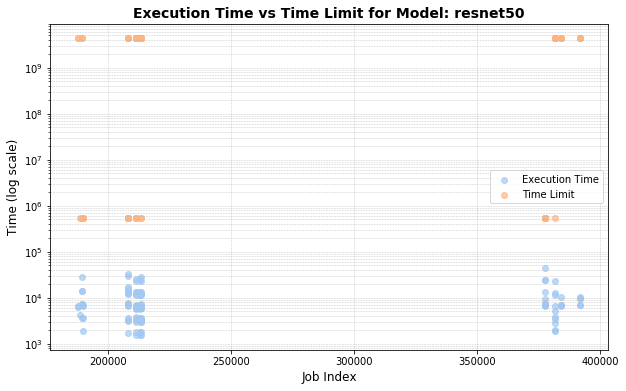

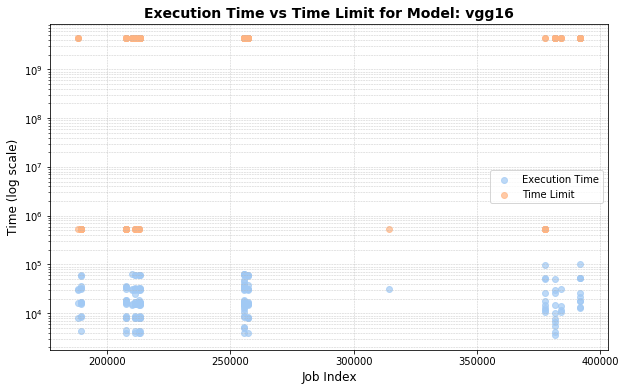

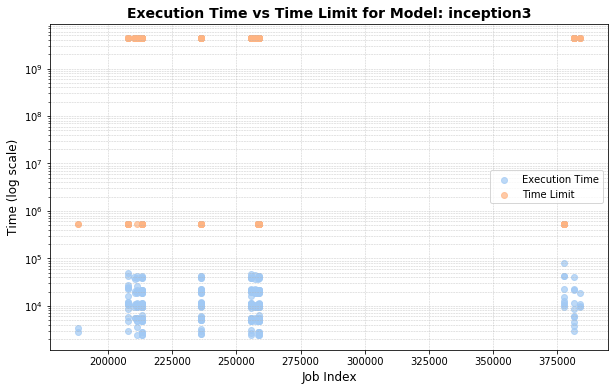

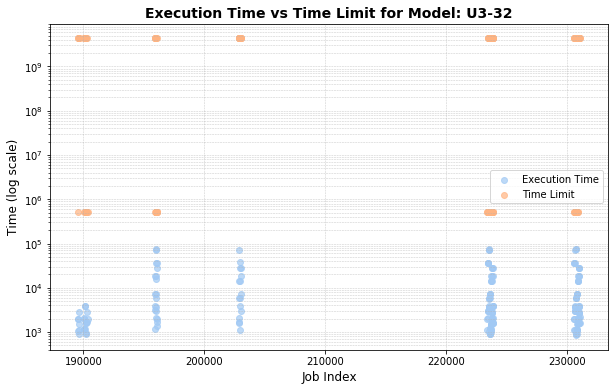

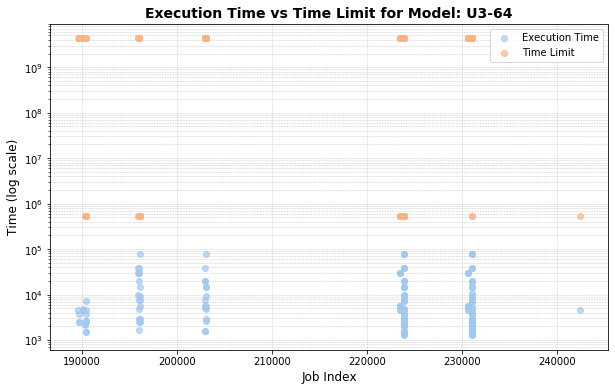

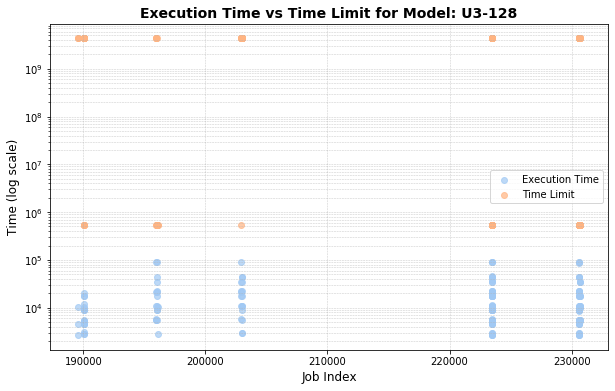

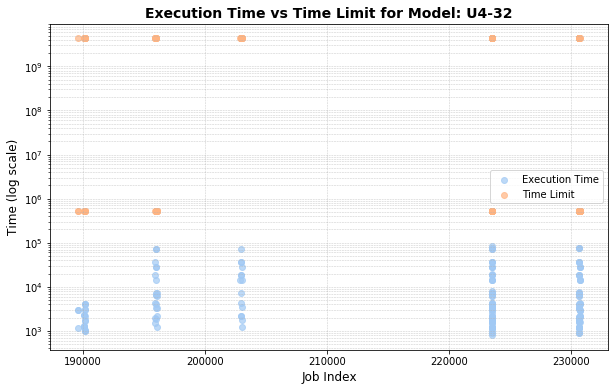

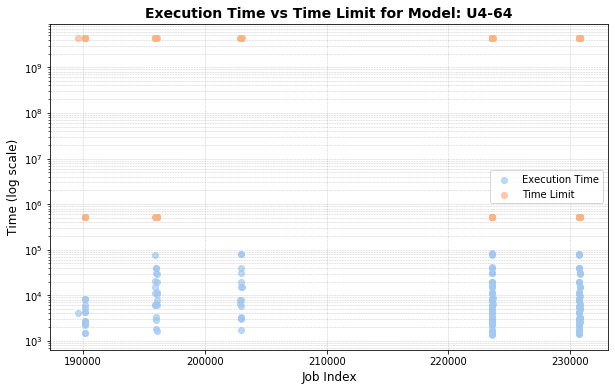

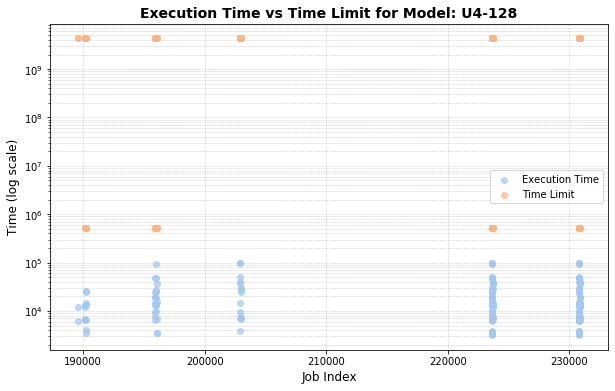

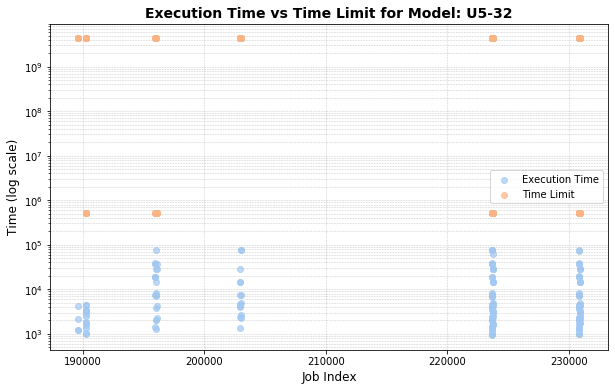

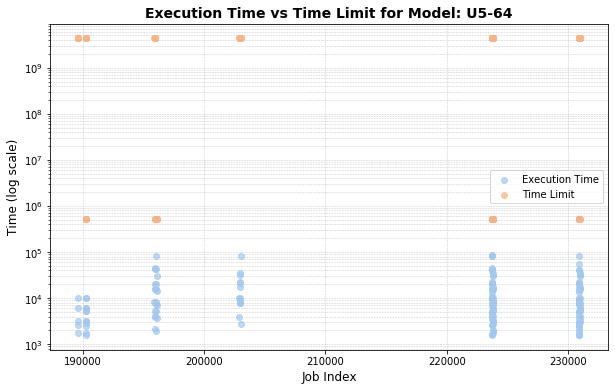

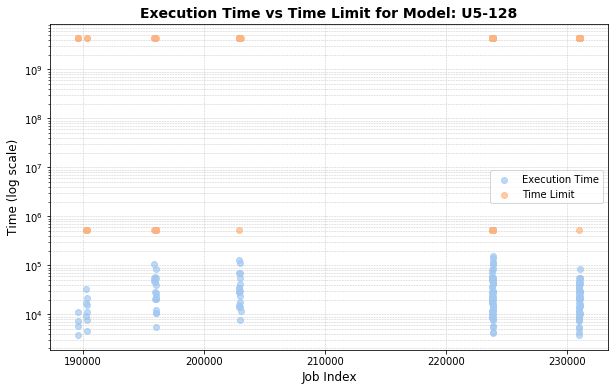

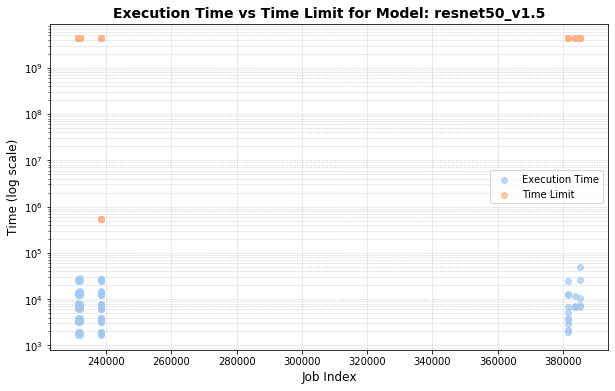

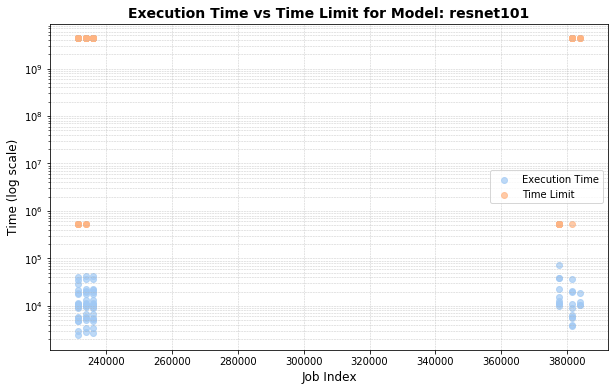

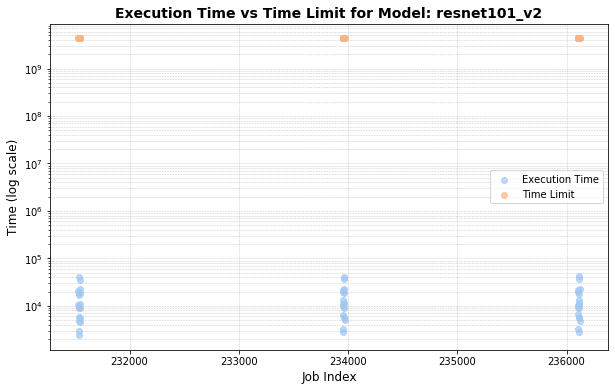

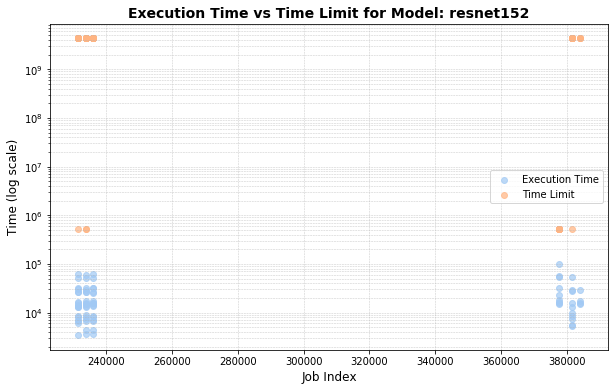

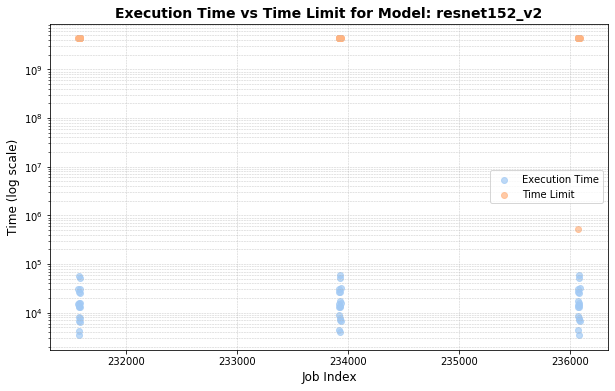

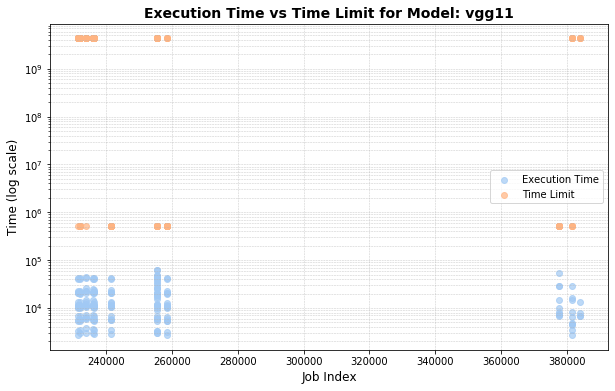

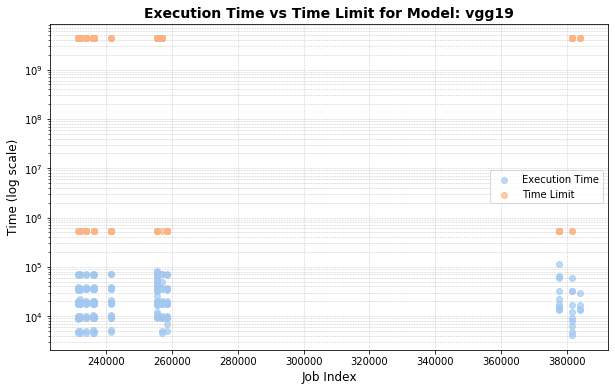

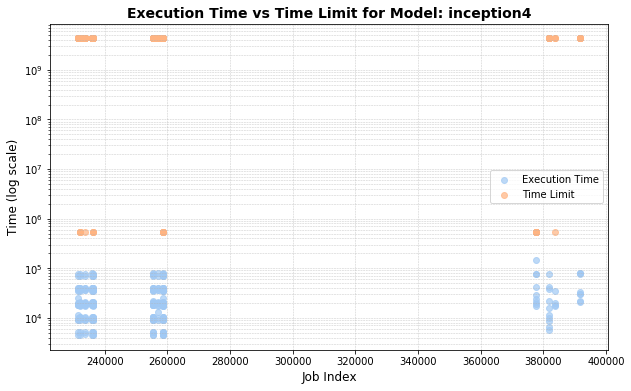

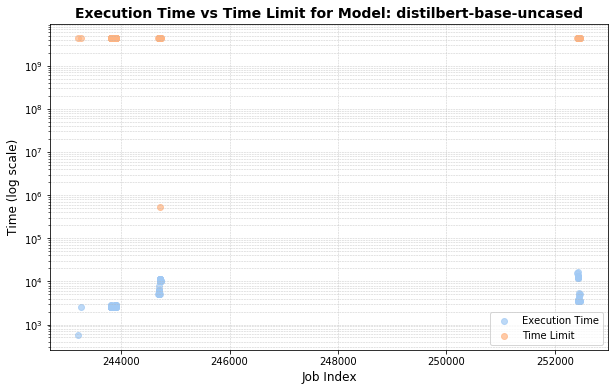

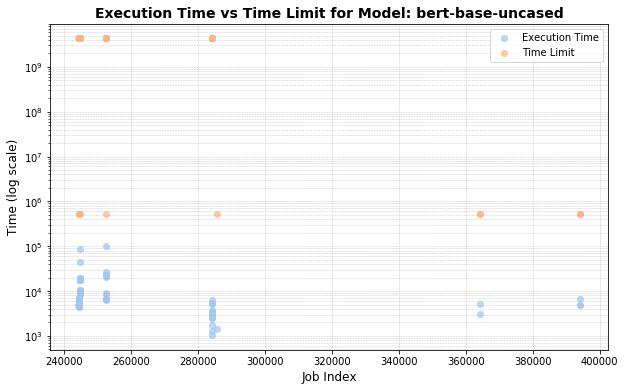

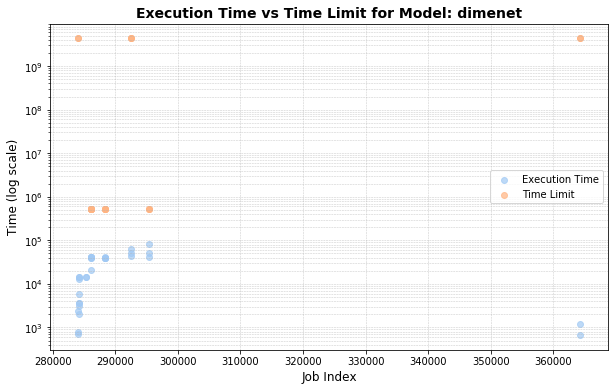

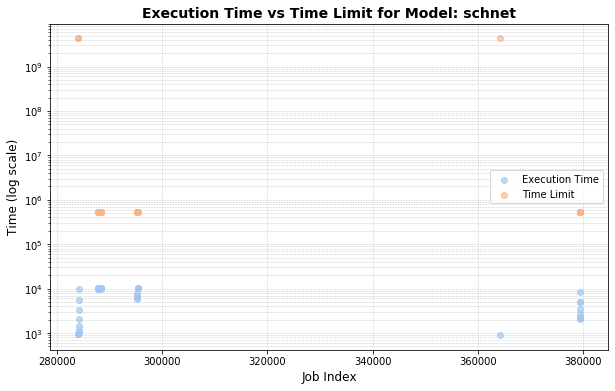

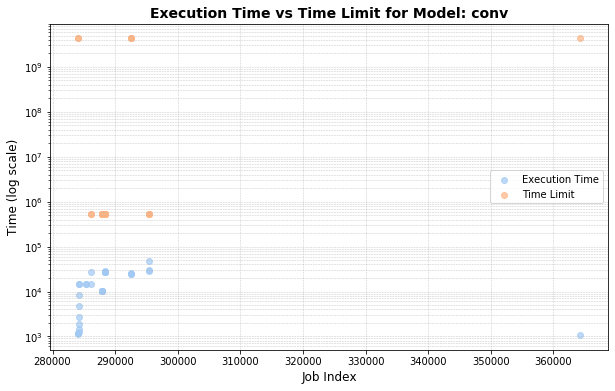

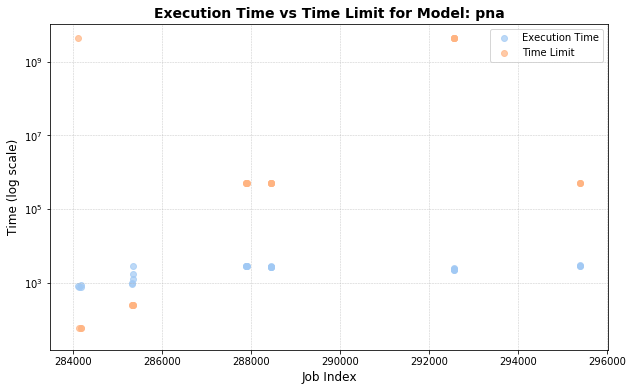

In [17]:
colors = sns.color_palette("pastel")  # Options: 'pastel', 'muted', etc.
execution_time_color = colors[0]  # Light blue
timelimit_color = colors[1]       # Light pink

for model, job_df in job_dfs.items():
    if not job_df.empty:
        job_df['execution_time'] = pd.to_numeric(job_df['execution_time'], errors='coerce').fillna(0).astype(int)
        job_df['timelimit'] = pd.to_numeric(job_df['timelimit'], errors='coerce').fillna(0).astype(int)
        job_df['execution_time'] = job_df['execution_time'].replace(0, 1)
        job_df['timelimit'] = job_df['timelimit'].replace(0, 1)

        plt.figure(figsize=(10, 6))
        plt.scatter(job_df.index, job_df['execution_time'], color=execution_time_color, label='Execution Time', alpha=0.7)
        plt.scatter(job_df.index, job_df['timelimit'], color=timelimit_color, label='Time Limit', alpha=0.7)

        plt.title(f'Execution Time vs Time Limit for Model: {model}', fontsize=14, fontweight='bold')
        plt.xlabel('Job Index', fontsize=12)
        plt.ylabel('Time (log scale)', fontsize=12)
        plt.yscale('log')  # Apply log scale to the y-axis
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Cute grid style

        # Display the plot
        plt.show()

    else:
        print(f"No data available for model: {model}")

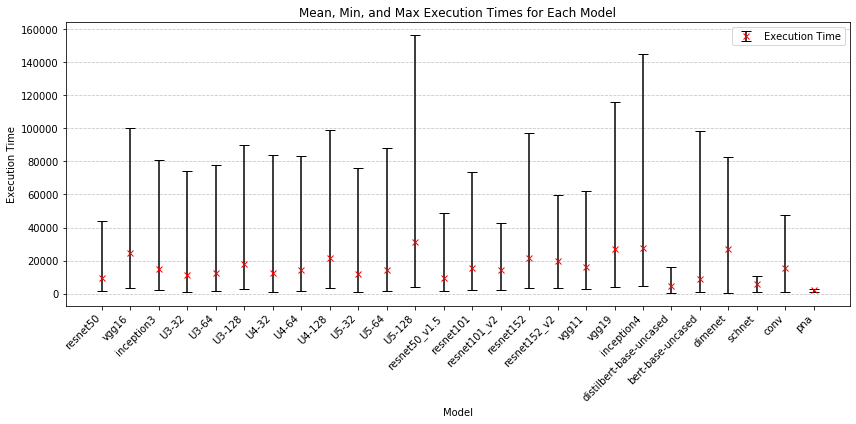

In [24]:
execution_time_stats = {}

# Calculate mean, min, and max for each model
for model, job_df in job_dfs.items():
    if not job_df.empty:
        mean_val = job_df['execution_time'].mean()
        min_val = job_df['execution_time'].min()
        max_val = job_df['execution_time'].max()
        execution_time_stats[model] = {'mean': mean_val, 'min': min_val, 'max': max_val}

# Extract data for plotting
models = list(execution_time_stats.keys())
means = [execution_time_stats[model]['mean'] for model in models]
mins = [execution_time_stats[model]['min'] for model in models]
maxs = [execution_time_stats[model]['max'] for model in models]

# Calculate error bars (difference between mean and min/max)
yerr = [
    [mean - min_val for mean, min_val in zip(means, mins)],  # Lower error (mean - min)
    [max_val - mean for mean, max_val in zip(means, maxs)]   # Upper error (max - mean)
]

# Plot the error bar chart
plt.figure(figsize=(12, 6))
plt.errorbar(models, means, yerr=yerr, fmt='x', capsize=5, color='red', ecolor='black', label='Execution Time')
plt.title('Mean, Min, and Max Execution Times for Each Model')
plt.xlabel('Model')
plt.ylabel('Execution Time')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


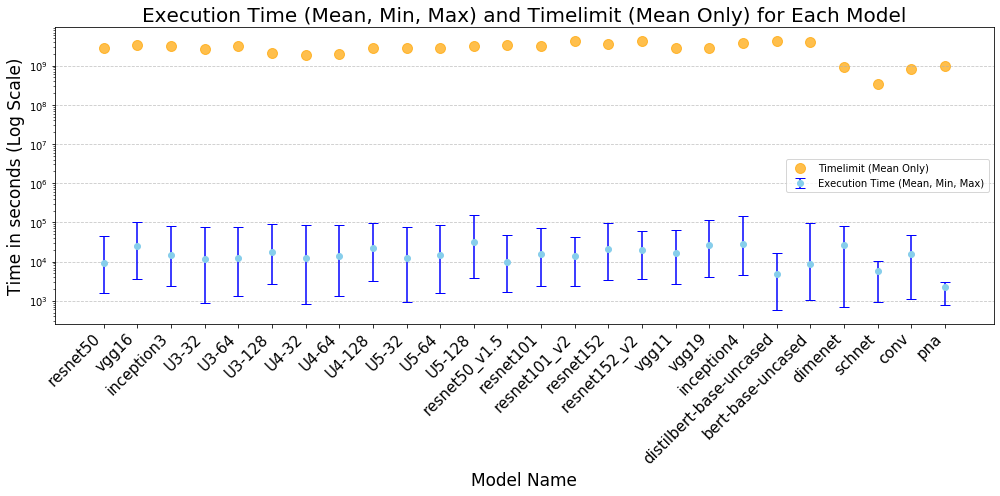

In [36]:
execution_time_stats = {}
timelimit_means = {}

# Calculate mean, min, and max for execution_time and mean for timelimit for each model
for model, job_df in job_dfs.items():
    job_df['timelimit'] = pd.to_numeric(job_df['timelimit'], errors='coerce').fillna(0).astype(int)
    if not job_df.empty:
        # Execution time stats
        execution_time_stats[model] = {
            'mean': job_df['execution_time'].mean(),
            'min': job_df['execution_time'].min(),
            'max': job_df['execution_time'].max()
        }
        # Timelimit mean
        timelimit_means[model] = job_df['timelimit'].mean()

models = list(execution_time_stats.keys())

execution_means = [execution_time_stats[model]['mean'] for model in models]
execution_mins = [execution_time_stats[model]['min'] for model in models]
execution_maxs = [execution_time_stats[model]['max'] for model in models]
execution_yerr = [
    [mean - min_val for mean, min_val in zip(execution_means, execution_mins)],  # Lower error
    [max_val - mean for mean, max_val in zip(execution_means, execution_maxs)]   # Upper error
]

timelimit_mean_values = [timelimit_means[model] for model in models]

plt.figure(figsize=(14, 7))

plt.errorbar(models, execution_means, yerr=execution_yerr, fmt='o', capsize=5, color='skyblue', ecolor='blue', 
             label='Execution Time (Mean, Min, Max)')

plt.scatter(models, timelimit_mean_values, color='orange', label='Timelimit (Mean Only)', s=100, alpha=0.7)

plt.title('Execution Time (Mean, Min, Max) and Timelimit (Mean Only) for Each Model',  fontsize=20)
plt.xlabel('Model Name',  fontsize=17)
plt.ylabel('Time in seconds (Log Scale)',  fontsize=17)
plt.yscale('log')  # Apply log scale
plt.xticks(rotation=45, ha='right',fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
exec_time_df = df_filtered[['id_job', 'id_user','execution_time',  "timelimit"]]

In [ ]:
# ---- Data Preprocessing for ML -----

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Parameters for model training
n_lags = 3  # Number of lagged features
alpha = 1.0  # Example value for alpha
beta = 1.0   # Example value for beta
epochs = 100  # Number of epochs to train


def preprocess_data(user_df, n_lags):
    """
    Preprocess the data by generating lag features, aligning requested CPU data,
    splitting into train/test datasets, and reshaping the data.

    Parameters:
    - group_data (pd.DataFrame): The input dataframe containing 'ncpu' and 'slots' columns.
    - lag (int): The number of lag features to generate.

    Returns:
    - X_train (np.ndarray): Training data features.
    - X_test (np.ndarray): Testing data features.
    - y_train (np.ndarray): Training data target values.
    - y_test (np.ndarray): Testing data target values.
    """

    data = user_df[['execution_time']].values 
    
    req_data =  user_df[['timelimit']].values

    # Generate lagged features
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[i-n_lags:i, 0])
        y.append(data[i, 0])
    X, y = np.array(X), np.array(y)    
    
    # Check if X and y are non-empty
    if X.size == 0 or y.size == 0:
        raise ValueError("No data to train on. Check your lag feature generation.")
    
    scaler_X = StandardScaler()
    X = scaler_X.fit_transform(X)
    
    # Reshape X for Conv1D
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # Scale targets
    scaler_y = StandardScaler()
    y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
    
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    train_data, y_req = train_test_split(req_data, test_size=0.2, shuffle=False)

    
    X_train = X_train.astype('float32')
    y_train = y_train.astype('float32')
    X_test = X_test.astype('float32')
    y_test = y_test.astype('float32')
    y_req = y_req.astype('float32')

    return X_train, X_test, y_train, y_test, scaler_y, y_req

In [ ]:
# ---- Creating Machine Learning Models -----
import tensorflow as tf
from tensorflow.keras import regularizers

def custom_loss(alpha, beta):
    def loss(y_true, y_pred):
        # Cast y_true and y_pred to float32 to ensure type consistency
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        error = y_true - y_pred
        squared_error = tf.square(error)
        
        weighted_error = tf.where(error > 0, alpha * squared_error, beta * squared_error)
        #loss = alpha * tf.reduce_mean(tf.square(error)) + beta * tf.reduce_mean(tf.abs(error))
        return tf.reduce_mean(weighted_error)
    return loss

# --- BNN ----

def build_bnn_model(input_shape, alpha, beta):
    bnn_model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01), input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(1)
    ])
    
    bnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss=custom_loss(alpha, beta),
                      metrics=['mean_squared_error'])
    return bnn_model

import matplotlib.pyplot as plt

def draw_prediction_results(y_test, y_pred, mean_y, y_req, title):    
    plt.figure(figsize=(10, 6))
    
    plt.plot(y_test, label='True Values', color='blue')
    plt.plot(y_pred, label='Predicted Values', color='orange')
    plt.plot(mean_y, label='Mean Value', color='green')
    plt.plot(y_req, label='Requested Values', color='red')
    
    plt.xlabel('Job submissions')
    plt.ylabel('Execution Time')
    plt.title(title)
    plt.legend()
    plt.show()
    

In [ ]:

encoder = OneHotEncoder(sparse=False) # To convert the string values in 'model' column to one-hot-encoded numbers

# Create a dictionary to store DataFrames for each user
user_dfs = {}

for user in known_jobs_df['id_user'].unique():
    user_df = known_jobs_df[known_jobs_df['id_user'] == user]
    user_dfs[user] = user_df
    # print(f"User: {user}, Row Count: {len(user_df)}")
    # Calculate row counts for unique model names
    model_counts = user_df['model'].value_counts()
    row_count = len(user_df)
    
    # Print the result
    #print(f'The user ID: {user}')
    #print(f'The total number of jobs: {row_count}')
    #print(model_counts)
    


for user, user_df in user_dfs.items():
    print(f"Processing User: {user}")
    
    X_encoded = encoder.fit_transform(user_df[['model']])
    
    # Apply K-means clustering
    n_clusters = user_df['model'].nunique()# Number of clusters = total number of different model names 
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    user_df['cluster'] = kmeans.fit_predict(X_encoded)

    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=user_df['cluster'], y=user_df['execution_time'], hue=user_df['cluster'], palette="viridis")
    plt.title(f'Execution Time Clusters for User {user}')
    plt.xlabel('Model')
    plt.ylabel('Execution Time')
    plt.legend(title='Cluster')
    plt.show()
    
    cluster_dfs = {}
    for cluster in range(n_clusters):
        cluster_dfs[cluster] = user_df[user_df['cluster'] == cluster]
        
    results = {}

    for cluster, cluster_df in cluster_dfs.items():
        
        cluster_df['timelimit'] = cluster_df['timelimit'].astype(int)
        cluster_df['timelimit'] = cluster_df['timelimit'].replace(4294967295, 100)
        
        X_train, X_test, y_train, y_test, scaler_y, y_req = preprocess_data(cluster_df, n_lags)

        input_shape = (X_train.shape[1], 1)
        model = build_bnn_model(input_shape, alpha, beta)

        history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)

        y_pred_scaled = model.predict(X_test).reshape(-1, 1)

        y_train = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
        mean_y = np.full_like(y_test, y_train.mean())

        y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten() + mean_y
        y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    
        mse = mean_squared_error(y_test, y_pred)
        print(f"Cluster {cluster}: Mean Squared Error = {mse}")

        results[cluster] = {'mse': mse, 'model': model, 'y_test': y_test, 'y_pred': y_pred}

        draw_prediction_results(y_test, y_pred, mean_y, y_req,  f'The Predicted Execution Time vs Actual Values for the User: {user}, Cluster: {cluster}')

        mse = mean_squared_error(y_test, y_pred)
        print(f"Mean Squared Error: {mse}")



In [ ]:
# --- DATA CLEANING: TRES COLUMNS ---

# Define the mapping for resource types
resource_mapping = {
    1: 'cpu',
    2: 'mem',
    3: 'energy',
    4: 'node',
    5: 'billing',
    6: 'fs',
    7: 'vmem',
    8: 'pages',
    1001: 'gpu:tesla',
    1002: 'gpu:volta'
}


def parse_resource_string(resource_str):
    """
    Parse the resource string and return a dictionary of resource types and values.
    """
    resource_dict = {}

    entries = resource_str.split(',')
    for entry in entries:
        if '=' in entry:
            key, value = entry.split('=') # Split by '='
            key = int(key)
            if key in resource_mapping:
                resource_dict[resource_mapping[key]] = int(value)
    return resource_dict


req_parsed_df = df_filtered["tres_req"].apply(parse_resource_string).apply(pd.Series)
alloc_parsed_df = df_filtered["tres_alloc"].apply(parse_resource_string).apply(pd.Series)


df_filtered = df_filtered.join(req_parsed_df, rsuffix='_req')
df_filtered = df_filtered.join(alloc_parsed_df, rsuffix='_alloc')

df_filtered

In [ ]:
print(df_filtered.columns.tolist())

In [ ]:
cpu_df = df_filtered[['id_job', 'id_user','cpu','cpu_alloc', 'job_type']]

print(f"Number of rows where 'cpu' and 'cpu_alloc' are different: {(cpu_df['cpu'] != cpu_df['cpu_alloc']).sum()}")

In [ ]:
import matplotlib.pyplot as plt

difference_boolean_series = cpu_df['cpu'] != cpu_df['cpu_alloc']

different_rows_df = cpu_df[difference_boolean_series]
print(different_rows_df['job_type'])

min_value = min(cpu_df['cpu'].min(), cpu_df['cpu_alloc'].min())
max_value = max(cpu_df['cpu'].max(), cpu_df['cpu_alloc'].max())


plt.figure(figsize=(10, 6))

plt.scatter(cpu_df['cpu'], cpu_df['cpu_alloc'], color='gray', label='All Points', alpha=0.5)
plt.scatter(different_rows_df['cpu'], different_rows_df['cpu_alloc'], color='red', label='Different Points', alpha=0.8)
plt.plot([min_value, max_value], [min_value, max_value], color='blue', linestyle='--', label='x=y Line')


plt.xlabel('CPU Requested')
plt.ylabel('CPU Allocated')
plt.title('Comparison of CPU vs. CPU Allocated')
plt.legend()
plt.grid(True)
cpu_df_sorted = cpu_df.sort_values(by='id_job')

plt.show()